# Calculating band indices <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `DEA Sandbox` and `NCI` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
Remote sensing indices are combinations of spectral bands used to highlight features in the data and the underlying landscape.
Using Digital Earth Australia's archive of analysis-ready satellite data, we can easily calculate a wide range of remote sensing indices that can be used to assist in mapping and monitoring features like vegetation and water consistently through time, or as inputs to machine learning or classification algorithms.


## Description
This notebook demonstrates how to:
 
* Calculate an index manually using `xarray`
* Calculate one or multiple indices using the function `calculate_indices` from `dea_bandindices.py`
 
***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_bandindices import calculate_indices
from dea_spatialtools import interpolate_2d, subpixel_contours
from dea_dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
create_local_dask_cluster()


/env/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41631 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:44411 Dashboard: /user/robbibt/proxy/41631/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Calculating_band_indices')

## Create a query and load satellite data
To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. 
We will use data from the Landsat 8 satellite:

In [3]:
# Roebuck
xmin, ymax = (122.254719, -18.155366)
xmax, ymin = (122.135270, -18.266834) 

# Pilbara
xmin, ymax = (117.535057, -20.614534)
xmax, ymin = ( 117.809731, -20.697634)

# NT
xmin, ymax = 135.80364970, -13.06364945
xmax, ymin = 136.15279294, -13.79379692

# Gold Coast
xmin, ymax = 153.35306815, -27.69805073
xmax, ymin = 153.62040169, -28.29843108




# Create a reusable query
query = {
    'x': (xmin, xmax),
    'y': (ymin, ymax),
    'time': ('2015-06', '2016-12'),
    'measurements': [
        'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1',
        'nbart_swir_2'
    ],
    'output_crs': 'EPSG:32750',
    'dask_chunks': {'x': 3000, 'y': 3000, 'time': 1},
    'resampling': {'*': 'cubic', 'fmask': 'nearest'},
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, products=['ga_ls8c_ard_3'], min_gooddata=0.90, mask_pixel_quality=False, **query)


../Scripts/dea_datahandling.py:286: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 18 out of 67 time steps with at least 90.0% good quality pixels
Returning 18 time steps as a dask array


### Plot the first image to see what our area looks like
We can use the `rgb` function to plot the first timestep in our dataset as a true colour RGB image:

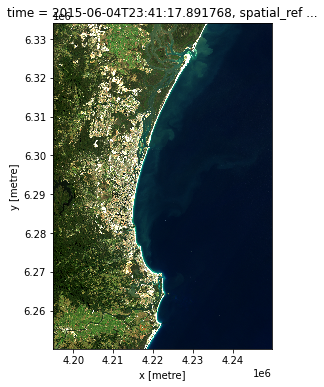

In [5]:
# Plot as an RGB image
index = 0
rgb(ds, index=index)


## Calculate an index for this area manually
One of the most commonly used remote sensing indices is the Normalised Difference Vegetation Index or `NDVI`. 
This index uses the ratio of the red and near-infrared (NIR) bands to identify live green vegetation.
The formula for NDVI is:

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

When interpreting this index, high values indicate vegetation, and low values indicate soil or water.

In the image above, vegetation shows up as green (NDVI > 0). 
Sand shows up as yellow (NDVI ~ 0) and water shows up as red (NDVI < 0).

## Calculate an index for the same area using `calculate_indices` function

The `calculate_indices` function provides an easier way to calculate a wide range of remote sensing indices, including:

- **AWEI_ns** (Automated Water Extraction Index,no shadows, Feyisa 2014)
- **AWEI_sh** (Automated Water Extraction Index,shadows, Feyisa 2014)
- **BAEI**    (Built-Up Area Extraction Index, Bouzekri et al. 2015) 
- **BAI**     (Burn Area Index, Martin 1998)
- **BSI**     (Bare Soil Index, Rikimaru et al. 2002)
- **BUI**     (Built-Up Index, He et al. 2010)
- **CMR**     (Clay Minerals Ratio, Drury 1987)
- **EVI**     (Enhanced Vegetation Index, Huete 2002)
- **FMR**     (Ferrous Minerals Ratio, Segal 1982)
- **IOR**     (Iron Oxide Ratio, Segal 1982)  
- **LAI**     (Leaf Area Index, Boegh 2002)
- **MNDWI**   (Modified Normalised Difference Water Index, Xu 1996) 
- **MSAVI**   (Modified Soil Adjusted Vegetation Index, Qi et al. 1994)              
- **NBI**     (New Built-Up Index, Jieli et al. 2010)
- **NBR**     (Normalised Burn Ratio, Lopez Garcia 1991)
- **NDBI**    (Normalised Difference Built-Up Index, Zha 2003)
- **NDCI**    (Normalised Difference Chlorophyll Index, Mishra & Mishra, 2012)
- **NDMI**    (Normalised Difference Moisture Index, Gao 1996)        
- **NDSI**    (Normalised Difference Snow Index, Hall 1995)
- **NDVI**    (Normalised Difference Vegetation Index, Rouse 1973)
- **NDWI**    (Normalised Difference Water Index, McFeeters 1996)
- **SAVI**    (Soil Adjusted Vegetation Index, Huete 1988)
- **TCB**     (Tasseled Cap Brightness, Crist 1985)
- **TCG**     (Tasseled Cap Greeness, Crist 1985)
- **TCW**     (Tasseled Cap Wetness, Crist 1985)
- **WI**      (Water Index, Fisher 2016) 

### Using `calculate_indices`, we get the same result:

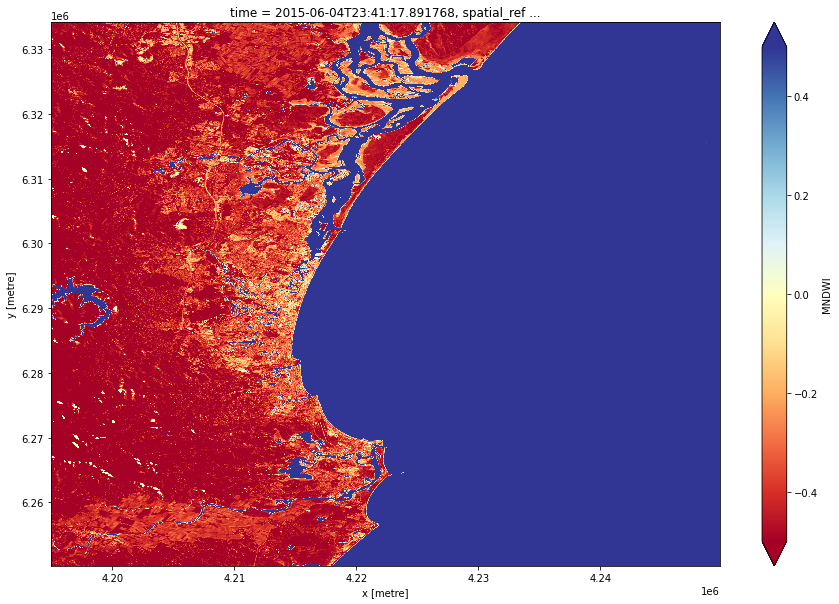

In [6]:
# Calculate NDVI using `calculate indices`
ds_ndvi = calculate_indices(ds, index='MNDWI', collection='ga_ls_3')

# Plot the results 
ds_ndvi.MNDWI.isel(time=index).plot(vmin=-0.5, vmax=0.5, cmap='RdYlBu', size=10)


> **Note**: when using the `calculate_indices` function, it is important to set the `collection` parameter correctly. 
This is because different satellite collections use different names for the same bands, which can lead to invalid results if not accounted for. 
For Landsat (i.e. GA Landsat Collection 3), specify `collection='ga_ls_3'`. 
For Sentinel 2 (i.e. GA Sentinel 2 Collection 1), specify `collection='ga_s2_1'`.

### Using calculate_indices to calculate multiple indices at once
The `calculate_indices` function makes it straightforward to calculate multiple remote sensing indices in one line of code.

In the example below, we will calculate `NDVI` as well as two common water indices: the Normalised Difference Water Index (`NDWI`), and the Modified Normalised Difference Index (`MNDWI`).
The new indices will appear in the list of `data_variables` below:

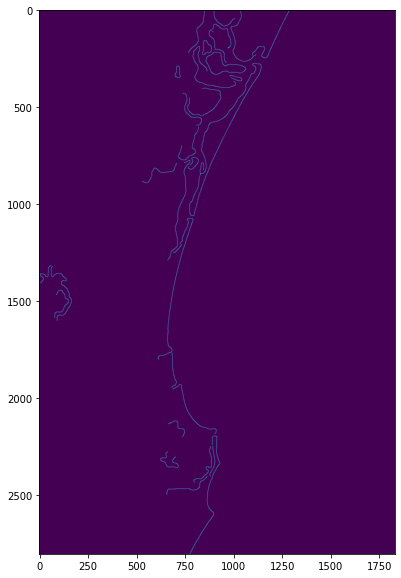

In [46]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, disk
from skimage import feature, filters, measure

da = ds_ndvi.MNDWI.isel(time=index)

mndwi = da.values
# dry_buffered = binary_erosion(mndwi > -0.5, disk(10))
# mndwi = np.where(mndwi > -0.5, mndwi, -0.5)
mndwi_smoothed = filters.gaussian(mndwi, sigma=3)

edges = feature.canny(mndwi_smoothed, sigma=5, low_threshold=0.3)

edges_labelled = measure.label(edges)
edges_info = measure.regionprops(edges_labelled)
large_edges = [i.label for i in edges_info if i.area > 150]
edges_out = np.isin(edges_labelled, large_edges)
fig = plt.figure(figsize=(10, 10))
plt.imshow(edges_out)


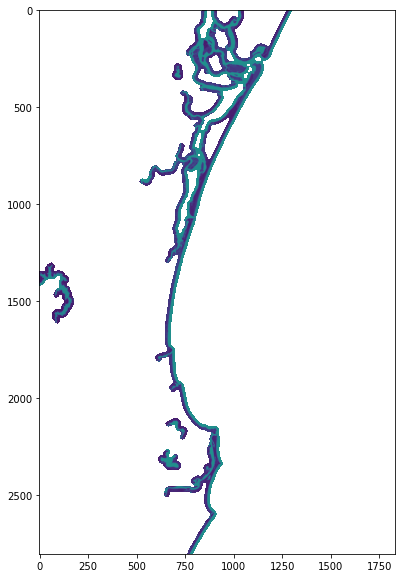

In [47]:
edge_buffered = binary_dilation(edges_out, disk(20))
mndwi_masked = np.where(edge_buffered, mndwi, np.nan)
fig = plt.figure(figsize=(10, 10))
plt.imshow(mndwi_masked)

(array([     0.,    589.,  80594.,  89401.,  39780.,  11066.,   6612.,
          6288.,  15822., 153903.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

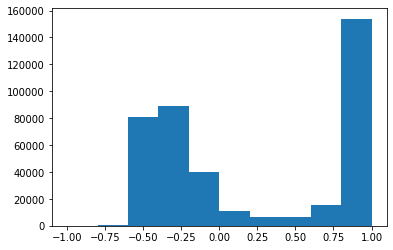

In [48]:
plt.hist(mndwi_masked[np.isfinite(mndwi_masked)], range=(-1, 1.0))

0.28625227188624347


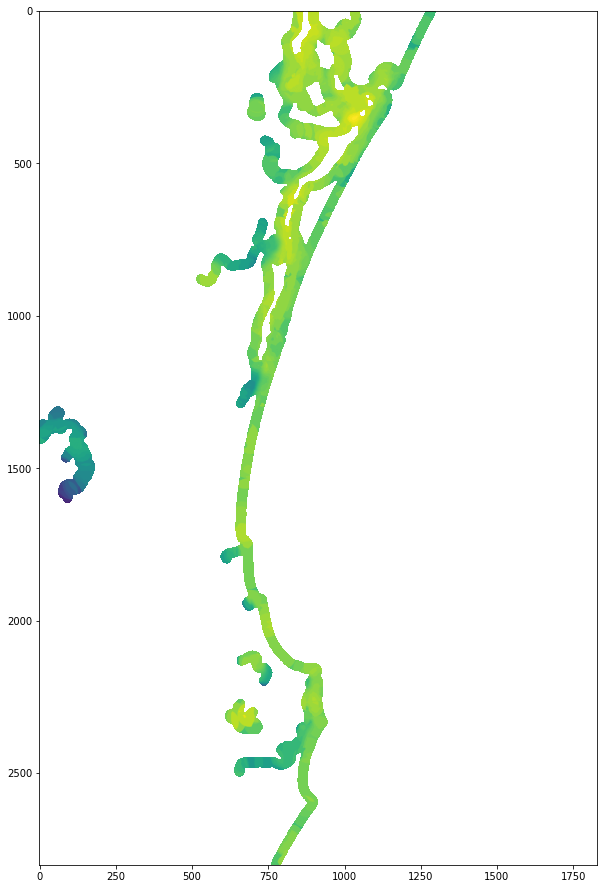

In [52]:
selem = disk(5)

from skimage.filters import threshold_otsu, rank

# local_otsu = rank.otsu(mndwi_masked, selem)
local_otsu = rank.otsu(mndwi_masked, disk(40)) / 255.0
local_otsu[~np.isfinite(mndwi_masked)] = np.nan
threshold_global_otsu = threshold_otsu(mndwi_masked[np.isfinite(mndwi_masked)])
global_otsu = mndwi_masked[np.isfinite(mndwi_masked)] >= threshold_global_otsu

print(threshold_global_otsu)
fig = plt.figure(figsize=(10, 20))
plt.imshow(local_otsu)

In [ ]:
import scipy.interpolate

y_coords, x_coords = np.nonzero(np.isfinite(mndwi_masked))
points_xy = np.vstack([x_coords, y_coords]).T
z_coords = local_otsu[np.isfinite(mndwi_masked)]
grid_y, grid_x = np.meshgrid(range(mndwi.shape[1]), range(mndwi.shape[0]))

local_otsu_interp = scipy.interpolate.griddata(points=points_xy, 
                           values=z_coords, 
                           method='nearest',
                           xi=(grid_y, grid_x))

local_otsu = filters.gaussian(local_otsu_interp, sigma=50)
fig = plt.figure(figsize=(10, 10))
plt.imshow(local_otsu)



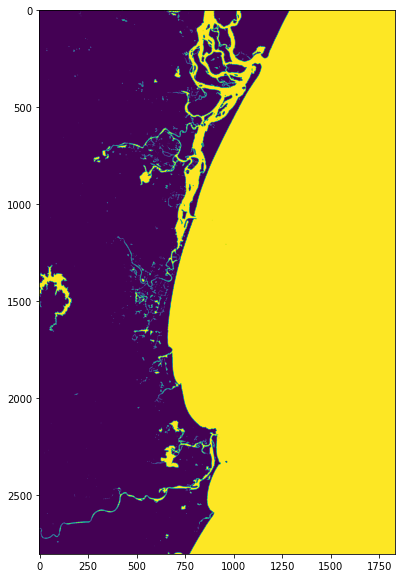

In [14]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.where(np.isfinite(mndwi), mndwi > threshold_global_otsu, np.nan))

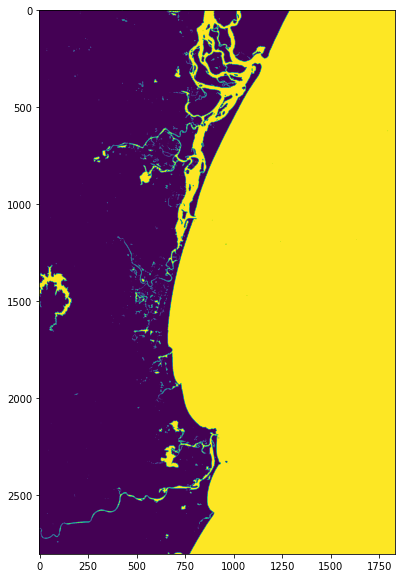

In [15]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(mndwi > local_otsu)


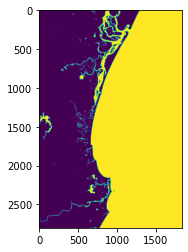

In [16]:
plt.imshow((mndwi - local_otsu) > 0)

In [17]:
otsu_da = xr.DataArray(local_otsu, coords=da.coords, dims=da.dims, attrs=ds_ndvi.attrs)
otsu_da

<xarray.DataArray (y: 2801, x: 1830)>
array([[0.44316685, 0.44316668, 0.44316652, ..., 0.40784314, 0.40784314,
        0.40784314],
       [0.44316851, 0.44316834, 0.44316817, ..., 0.40784314, 0.40784314,
        0.40784314],
       [0.44317026, 0.44317008, 0.4431699 , ..., 0.40784314, 0.40784314,
        0.40784314],
       ...,
       [0.36078839, 0.36078868, 0.36078899, ..., 0.43137255, 0.43137255,
        0.43137255],
       [0.36078839, 0.36078868, 0.36078899, ..., 0.43137255, 0.43137255,
        0.43137255],
       [0.36078839, 0.36078868, 0.36078899, ..., 0.43137255, 0.43137255,
        0.43137255]])
Coordinates:
    time         datetime64[ns] 2015-06-04T23:41:17.891768
  * y            (y) float64 6.334e+06 6.334e+06 6.334e+06 ... 6.25e+06 6.25e+06
  * x            (x) float64 4.195e+06 4.195e+06 4.195e+06 ... 4.25e+06 4.25e+06
    spatial_ref  int32 32750
Attributes:
    crs:           EPSG:32750
    grid_mapping:  spatial_ref

In [22]:
da

<xarray.DataArray 'MNDWI' (y: 2801, x: 1830)>
array([[-0.43765281, -0.43309353, -0.48571429, ...,  0.66473988,
         0.66863905,  0.69512195],
       [-0.4940457 , -0.45780795, -0.43565038, ...,  0.65909091,
         0.67058824,  0.67664671],
       [-0.50473186, -0.49489449, -0.48933957, ...,  0.65882353,
         0.70552147,  0.67073171],
       ...,
       [-0.53387726, -0.52514793, -0.4642369 , ...,  0.84496124,
         0.83333333,  0.83739837],
       [-0.5314895 , -0.5484558 , -0.54864434, ...,  0.85365854,
         0.8487395 ,  0.85365854],
       [-0.5242915 , -0.52668416, -0.5557759 , ...,  0.81666667,
         0.83333333,  0.8677686 ]])
Coordinates:
    time         datetime64[ns] 2015-06-04T23:41:17.891768
  * y            (y) float64 6.334e+06 6.334e+06 6.334e+06 ... 6.25e+06 6.25e+06
  * x            (x) float64 4.195e+06 4.195e+06 4.195e+06 ... 4.25e+06 4.25e+06
    spatial_ref  int32 32750

In [23]:
subpixel_contours(da=(da - otsu_da), z_values=0, crs=ds_ndvi.crs, output_path='coastline_local_otsu.geojson', min_vertices=20)
subpixel_contours(da=da, z_values=threshold_global_otsu, crs=ds_ndvi.crs, output_path='coastline_global_otsu.geojson', min_vertices=20)
subpixel_contours(da=da, z_values=0, crs=ds_ndvi.crs, output_path='coastline_zero.geojson', min_vertices=20)

Operating in multiple z-value, single array mode
Writing contours to coastline_local_otsu.geojson


/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Operating in multiple z-value, single array mode
Writing contours to coastline_global_otsu.geojson
Operating in multiple z-value, single array mode
Writing contours to coastline_zero.geojson


,z_value,geometry
0,0,"MULTILINESTRING ((4216878.126 6334185.000, 421..."


In [26]:
from datacube.utils.cog import write_cog

write_cog(geo_im=da,
          fname='example_mndwi.tif',
          overwrite=True)

write_cog(geo_im=ds_ndvi[['nbart_blue', 'nbart_green', 'nbart_red']].isel(time=index).to_array().compute(),
          fname='example_true.tif',
          overwrite=True)


write_cog(geo_im=ds_ndvi[['nbart_swir_2', 'nbart_nir', 'nbart_green']].isel(time=index).to_array().compute(),
          fname='example_false.tif',
          overwrite=True)

PosixPath('example_false.tif')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)